In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import itertools
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import nltk
import re
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Model
from scipy import sparse
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import TfidfTransformer
nltk.download('stopwords')
nltk.download('punkt')

data=pd.read_csv('/content/drive/MyDrive/lfwcrop_grey/Text_Similarity_Data4.csv')
data.head(1)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Unique_ID,text1,text2
0,0,savvy searchers fail to spot ads internet sear...,newcastle 2-1 bolton kieron dyer smashed home ...


In [ ]:
texts = pd.read_csv('/content/drive/MyDrive/lfwcrop_grey/Text_Similarity_Data4.csv')
df=texts
text1 = [x for x in texts['text1']]
print(len(text1))
print(text1)


4
['savvy searchers fail to spot ads internet search engine users are an odd mix of naive and sophisticated  suggests a report into search habits.  ', 'millions to miss out on the net by 2025  40% of the uk s population will still be without internet access at home  says a study.  ', 'young debut cut short by ginepri fifteen-year-old donald young s first appearance in an atp tennis tournament proved brief as the teenager went out in round one of the san jose open. ', 'diageo to buy us wine firm diageo  the world s biggest spirits company  has agreed to buy californian wine company chalone for $260m (?134m) in an all-cash deal. ']


In [ ]:
text2 = [x for x in texts['text2']]
print(len(text2))
print(text2)

4
['newcastle 2-1 bolton kieron dyer smashed home the winner to end bolton s 10-game unbeaten run. ', 'nasdaq planning $100m share sale the owner of the technology-dominated nasdaq stock index plans to sell shares to the public and list itself on the market it operates. ', 'ruddock backs yapp s credentials wales coach mike ruddock says john yapp has what it takes as an international.  ', 'mci shares climb on takeover bid shares in us phone company mci have risen on speculation that it is in takeover talks. ']


In [ ]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)


In [ ]:
def text_preprocessing(
        text: list,
        punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
        stop_words=['to','an','if','and', 'a', 'is', 'the', 'in', 'be', 'will', 'was', 'but', 'this', 'were', 'with', 'of', 'also',
                    'on', '.', 'for', 'any', 'its', 'and', 'are', 'from', 'both', 'as']
) -> list:
    """
    A method to preproces text
    """
    for x in text.lower():
        if x in punctuations:
            text = text.replace(x, "")

    # Removing words that have numbers in them
    text = re.sub(r'\w*\d\w*', '', text)

    # Removing digits
    text = re.sub(r'[0-9]+', '', text)

    # Cleaning the whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Setting every word to lower
    text = text.lower()

    # Converting all our text to a list
    text = text.split(' ')

    # Droping empty strings
    text = [x for x in text if x != '']

    # Droping stop words
    text = [x for x in text if x not in stop_words]

    return text



In [ ]:
def window( w, t)-> list:
    window=w
    texts=t
    # Creating a placeholder for the scanning of the word list
    word_lists = []
    all_text = []
    for text in texts:

        # Cleaning the text
        text = remove_stopwords(text)
        text = text_preprocessing(text)

        # Appending to the all text list
        all_text += text

        # Creating a context dictionary
        for i, word in enumerate(text):
            for w in range(window):
                # Getting the context that is ahead by *window* words
                if i + 1 + w < len(text):
                    word_lists.append([word] + [text[(i + 1 + w)]])
                # Getting the context that is behind by *window* words
                if i - w - 1 >= 0:
                    word_lists.append([word] + [text[(i - w - 1)]])

    return word_lists , all_text


In [ ]:
# Defining the window for context
windo = 2
word_list1 , all_text1 = window(windo,text1)
word_list2 , all_text2 = window(windo,text2)

In [ ]:
word_list1

[['savvy', 'searchers'],
 ['savvy', 'fail'],
 ['searchers', 'fail'],
 ['searchers', 'savvy'],
 ['searchers', 'spot'],
 ['fail', 'spot'],
 ['fail', 'searchers'],
 ['fail', 'ads'],
 ['fail', 'savvy'],
 ['spot', 'ads'],
 ['spot', 'fail'],
 ['spot', 'internet'],
 ['spot', 'searchers'],
 ['ads', 'internet'],
 ['ads', 'spot'],
 ['ads', 'search'],
 ['ads', 'fail'],
 ['internet', 'search'],
 ['internet', 'ads'],
 ['internet', 'engine'],
 ['internet', 'spot'],
 ['search', 'engine'],
 ['search', 'internet'],
 ['search', 'users'],
 ['search', 'ads'],
 ['engine', 'users'],
 ['engine', 'search'],
 ['engine', 'odd'],
 ['engine', 'internet'],
 ['users', 'odd'],
 ['users', 'engine'],
 ['users', 'mix'],
 ['users', 'search'],
 ['odd', 'mix'],
 ['odd', 'users'],
 ['odd', 'naive'],
 ['odd', 'engine'],
 ['mix', 'naive'],
 ['mix', 'odd'],
 ['mix', 'sophisticated'],
 ['mix', 'users'],
 ['naive', 'sophisticated'],
 ['naive', 'mix'],
 ['naive', 'suggests'],
 ['naive', 'odd'],
 ['sophisticated', 'suggests'],
 [

In [ ]:
word_list2

[['newcastle', 'bolton'],
 ['newcastle', 'kieron'],
 ['bolton', 'kieron'],
 ['bolton', 'newcastle'],
 ['bolton', 'dyer'],
 ['kieron', 'dyer'],
 ['kieron', 'bolton'],
 ['kieron', 'smashed'],
 ['kieron', 'newcastle'],
 ['dyer', 'smashed'],
 ['dyer', 'kieron'],
 ['dyer', 'home'],
 ['dyer', 'bolton'],
 ['smashed', 'home'],
 ['smashed', 'dyer'],
 ['smashed', 'winner'],
 ['smashed', 'kieron'],
 ['home', 'winner'],
 ['home', 'smashed'],
 ['home', 'end'],
 ['home', 'dyer'],
 ['winner', 'end'],
 ['winner', 'home'],
 ['winner', 'bolton'],
 ['winner', 'smashed'],
 ['end', 'bolton'],
 ['end', 'winner'],
 ['end', 'unbeaten'],
 ['end', 'home'],
 ['bolton', 'unbeaten'],
 ['bolton', 'end'],
 ['bolton', 'run'],
 ['bolton', 'winner'],
 ['unbeaten', 'run'],
 ['unbeaten', 'bolton'],
 ['unbeaten', 'end'],
 ['run', 'unbeaten'],
 ['run', 'bolton'],
 ['nasdaq', 'planning'],
 ['nasdaq', 'share'],
 ['planning', 'share'],
 ['planning', 'nasdaq'],
 ['planning', 'sale'],
 ['share', 'sale'],
 ['share', 'planning'],

In [ ]:
all_text1

['savvy',
 'searchers',
 'fail',
 'spot',
 'ads',
 'internet',
 'search',
 'engine',
 'users',
 'odd',
 'mix',
 'naive',
 'sophisticated',
 'suggests',
 'report',
 'search',
 'habits',
 'millions',
 'miss',
 'net',
 'uk',
 'population',
 'still',
 'without',
 'internet',
 'access',
 'home',
 'says',
 'study',
 'young',
 'debut',
 'cut',
 'short',
 'ginepri',
 'fifteenyearold',
 'donald',
 'young',
 'first',
 'appearance',
 'atp',
 'tennis',
 'tournament',
 'proved',
 'brief',
 'teenager',
 'went',
 'round',
 'one',
 'san',
 'jose',
 'open',
 'diageo',
 'buy',
 'us',
 'wine',
 'firm',
 'diageo',
 'world',
 'biggest',
 'spirits',
 'company',
 'agreed',
 'buy',
 'californian',
 'wine',
 'company',
 'chalone',
 'allcash',
 'deal']

In [ ]:
def create_unique_word_dict(text: list) -> dict:
    """
    A method that creates a dictionary where the keys are unique words
    and key values are indices
    """
    # Getting all the unique words from our text and sorting them alphabetically
    words = list(set(text))
    words.sort()

    # Creating the dictionary for the unique words
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({ word: i   })

    return unique_word_dict


{'access': 0, 'ads': 1, 'agreed': 2, 'allcash': 3, 'appearance': 4, 'atp': 5, 'biggest': 6, 'brief': 7, 'buy': 8, 'californian': 9, 'chalone': 10, 'company': 11, 'cut': 12, 'deal': 13, 'debut': 14, 'diageo': 15, 'donald': 16, 'engine': 17, 'fail': 18, 'fifteenyearold': 19, 'firm': 20, 'first': 21, 'ginepri': 22, 'habits': 23, 'home': 24, 'internet': 25, 'jose': 26, 'millions': 27, 'miss': 28, 'mix': 29, 'naive': 30, 'net': 31, 'odd': 32, 'one': 33, 'open': 34, 'population': 35, 'proved': 36, 'report': 37, 'round': 38, 'san': 39, 'savvy': 40, 'says': 41, 'search': 42, 'searchers': 43, 'short': 44, 'sophisticated': 45, 'spirits': 46, 'spot': 47, 'still': 48, 'study': 49, 'suggests': 50, 'teenager': 51, 'tennis': 52, 'tournament': 53, 'uk': 54, 'us': 55, 'users': 56, 'went': 57, 'wine': 58, 'without': 59, 'world': 60, 'young': 61}
['access', 'ads', 'agreed', 'allcash', 'appearance', 'atp', 'biggest', 'brief', 'buy', 'californian', 'chalone', 'company', 'cut', 'deal', 'debut', 'diageo', 'd

66it [00:00, 638.44it/s]

['savvy', 'searchers']
savvy 40
searchers 43
['savvy', 'fail']
savvy 40
fail 18
['searchers', 'fail']
searchers 43
fail 18
['searchers', 'savvy']
searchers 43
savvy 40
['searchers', 'spot']
searchers 43
spot 47
['fail', 'spot']
fail 18
spot 47
['fail', 'searchers']
fail 18
searchers 43
['fail', 'ads']
fail 18
ads 1
['fail', 'savvy']
fail 18
savvy 40
['spot', 'ads']
spot 47
ads 1
['spot', 'fail']
spot 47
fail 18
['spot', 'internet']
spot 47
internet 25
['spot', 'searchers']
spot 47
searchers 43
['ads', 'internet']
ads 1
internet 25
['ads', 'spot']
ads 1
spot 47
['ads', 'search']
ads 1
search 42
['ads', 'fail']
ads 1
fail 18
['internet', 'search']
internet 25
search 42
['internet', 'ads']
internet 25
ads 1
['internet', 'engine']
internet 25
engine 17
['internet', 'spot']
internet 25
spot 47
['search', 'engine']
search 42
engine 17
['search', 'internet']
search 42
internet 25
['search', 'users']
search 42
users 56
['search', 'ads']
search 42
ads 1
['engine', 'users']
engine 17
users 56
['

252it [00:00, 782.30it/s]


went 57
teenager 51
['went', 'one']
went 57
one 33
['went', 'brief']
went 57
brief 7
['round', 'one']
round 38
one 33
['round', 'went']
round 38
went 57
['round', 'san']
round 38
san 39
['round', 'teenager']
round 38
teenager 51
['one', 'san']
one 33
san 39
['one', 'round']
one 33
round 38
['one', 'jose']
one 33
jose 26
['one', 'went']
one 33
went 57
['san', 'jose']
san 39
jose 26
['san', 'one']
san 39
one 33
['san', 'open']
san 39
open 34
['san', 'round']
san 39
round 38
['jose', 'open']
jose 26
open 34
['jose', 'san']
jose 26
san 39
['jose', 'one']
jose 26
one 33
['open', 'jose']
open 34
jose 26
['open', 'san']
open 34
san 39
['diageo', 'buy']
diageo 15
buy 8
['diageo', 'us']
diageo 15
us 55
['buy', 'us']
buy 8
us 55
['buy', 'diageo']
buy 8
diageo 15
['buy', 'wine']
buy 8
wine 58
['us', 'wine']
us 55
wine 58
['us', 'buy']
us 55
buy 8
['us', 'firm']
us 55
firm 20
['us', 'diageo']
us 55
diageo 15
['wine', 'firm']
wine 58
firm 20
['wine', 'us']
wine 58
us 55
['wine', 'diageo']
wine 58


[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 

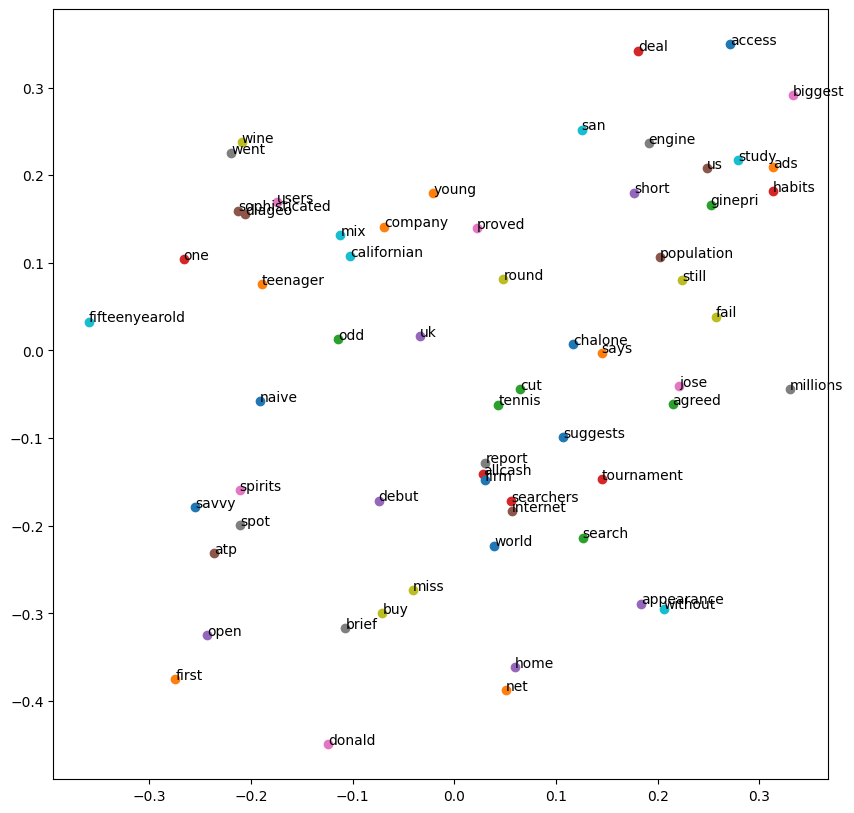

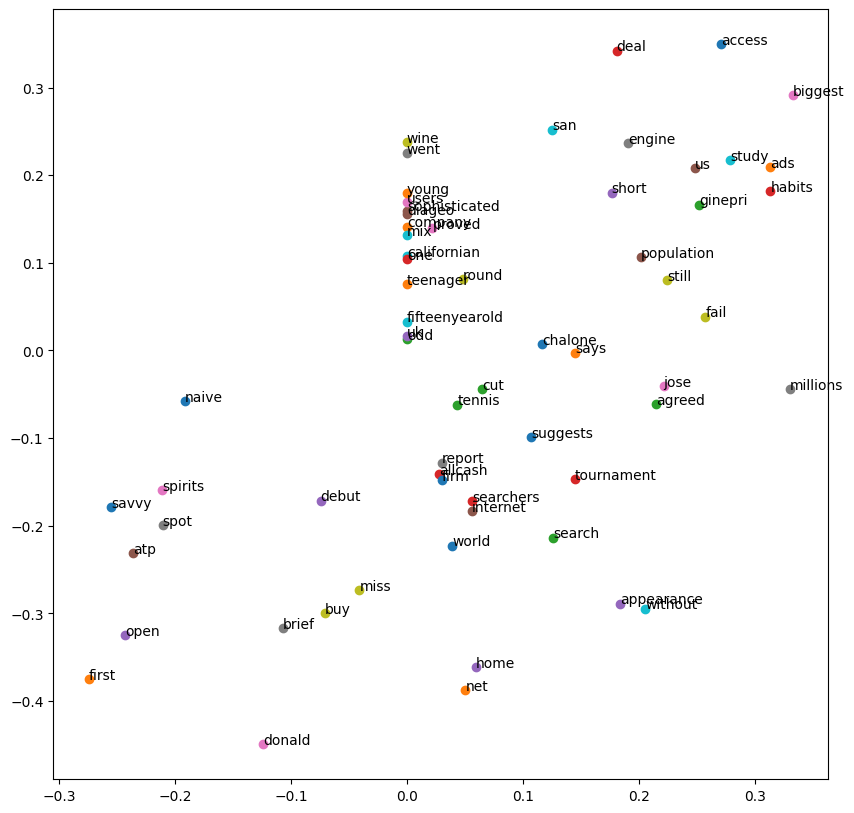

In [ ]:
# DOC1
unique_word_dict1 = create_unique_word_dict(all_text1)
# Defining the number of features (unique words)
n_words = len(unique_word_dict1)
print(unique_word_dict1)

# Getting all the unique words
words = list(unique_word_dict1.keys())
print(words)

# Creating the X and Y matrices using one hot encoding
print(n_words)
X = []
Y = []
for i, word_list in tqdm(enumerate(word_list1)):
    # Getting the indices
    print(word_list)
    main_word_index = unique_word_dict1.get(word_list[0])
    context_word_index = unique_word_dict1.get(word_list[1])
    # print (word_list)
    print(word_list[0], main_word_index)
    print(word_list[1], context_word_index)

    # Creating the placeholders
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

# Converting the matrices into a sparse format because the vast majority of the data are 0s
print(X)
print(Y)
XX = tf.convert_to_tensor(X, dtype=tf.float32)
YY = tf.convert_to_tensor(Y, dtype=tf.float32)
print(XX.shape)
print(YY.shape)

def CreateModel():
    # Defining the size of the embedding
    embed_size = 2
    # Defining the neural network

    inp = Input(shape=XX.shape[1])
    x = Dense(units=embed_size, activation='linear')(inp)
    x = Dense(units=YY.shape[1], activation='softmax')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.summary()
    return model

model = CreateModel()
# Optimizing the network weights
model.fit( x=XX,y=YY,  batch_size=10, epochs=15)

# The input layer
weights = model.get_weights()[0]
print(weights.shape)
print(weights[1][1])
print(weights)

#get the weight for each unique word
embedding_dict1 = {}
for word in words: #to pick the a row of weight of two values for each unique word
    embedding_dict1.update({
        word: weights[unique_word_dict1.get(word)]  })

print(embedding_dict1)

#plot 1
plt.figure(figsize=(10, 10))
i = 0
for word in list(unique_word_dict1.keys()):
    print(i, ' >> ', word)
    coord = embedding_dict1.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))
    i = i + 1

# The input layer
weights = model.get_weights()[0]

#plot2
plt.figure(figsize=(10, 10))
i = 0
for word in list(unique_word_dict1.keys()):
    print(i, ' >> ', word)
    coord = embedding_dict1.get(word)
    if weights[i][0] < 0 and weights[i][1] > 0:
        plt.scatter(0, weights[i][1])
        plt.annotate(word, (0, weights[i][1]))
    else:
        plt.scatter(weights[i][0], weights[i][1])
        plt.annotate(word, (weights[i][0], weights[i][1]))

    i = i + 1

{'backs': 0, 'bid': 1, 'bolton': 2, 'climb': 3, 'coach': 4, 'company': 5, 'credentials': 6, 'dyer': 7, 'end': 8, 'home': 9, 'index': 10, 'international': 11, 'john': 12, 'kieron': 13, 'list': 14, 'market': 15, 'mci': 16, 'mike': 17, 'nasdaq': 18, 'newcastle': 19, 'operates': 20, 'owner': 21, 'phone': 22, 'planning': 23, 'plans': 24, 'public': 25, 'risen': 26, 'ruddock': 27, 'run': 28, 'sale': 29, 'says': 30, 'sell': 31, 'share': 32, 'shares': 33, 'smashed': 34, 'speculation': 35, 'stock': 36, 'takeover': 37, 'takes': 38, 'talks': 39, 'technologydominated': 40, 'unbeaten': 41, 'us': 42, 'wales': 43, 'winner': 44, 'yapp': 45}
['backs', 'bid', 'bolton', 'climb', 'coach', 'company', 'credentials', 'dyer', 'end', 'home', 'index', 'international', 'john', 'kieron', 'list', 'market', 'mci', 'mike', 'nasdaq', 'newcastle', 'operates', 'owner', 'phone', 'planning', 'plans', 'public', 'risen', 'ruddock', 'run', 'sale', 'says', 'sell', 'share', 'shares', 'smashed', 'speculation', 'stock', 'takeove

192it [00:00, 2240.82it/s]

['newcastle', 'bolton']
newcastle 19
bolton 2
['newcastle', 'kieron']
newcastle 19
kieron 13
['bolton', 'kieron']
bolton 2
kieron 13
['bolton', 'newcastle']
bolton 2
newcastle 19
['bolton', 'dyer']
bolton 2
dyer 7
['kieron', 'dyer']
kieron 13
dyer 7
['kieron', 'bolton']
kieron 13
bolton 2
['kieron', 'smashed']
kieron 13
smashed 34
['kieron', 'newcastle']
kieron 13
newcastle 19
['dyer', 'smashed']
dyer 7
smashed 34
['dyer', 'kieron']
dyer 7
kieron 13
['dyer', 'home']
dyer 7
home 9
['dyer', 'bolton']
dyer 7
bolton 2
['smashed', 'home']
smashed 34
home 9
['smashed', 'dyer']
smashed 34
dyer 7
['smashed', 'winner']
smashed 34
winner 44
['smashed', 'kieron']
smashed 34
kieron 13
['home', 'winner']
home 9
winner 44
['home', 'smashed']
home 9
smashed 34
['home', 'end']
home 9
end 8
['home', 'dyer']
home 9
dyer 7
['winner', 'end']
winner 44
end 8
['winner', 'home']
winner 44
home 9
['winner', 'bolton']
winner 44
bolton 2
['winner', 'smashed']
winner 44
smashed 34
['end', 'bolton']
end 8
bolton 

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.

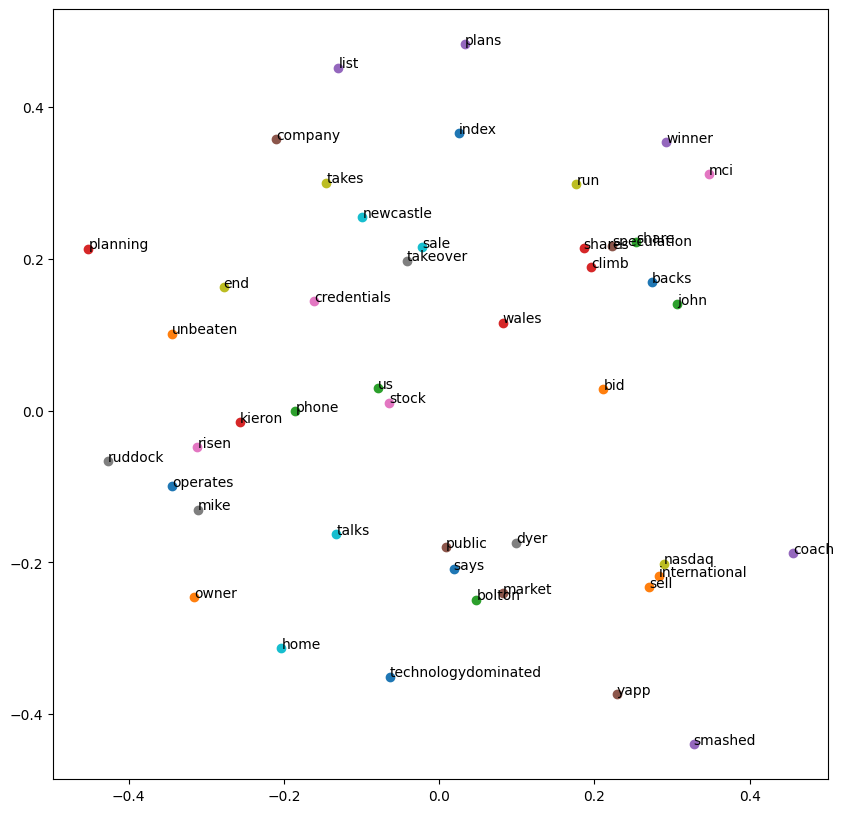

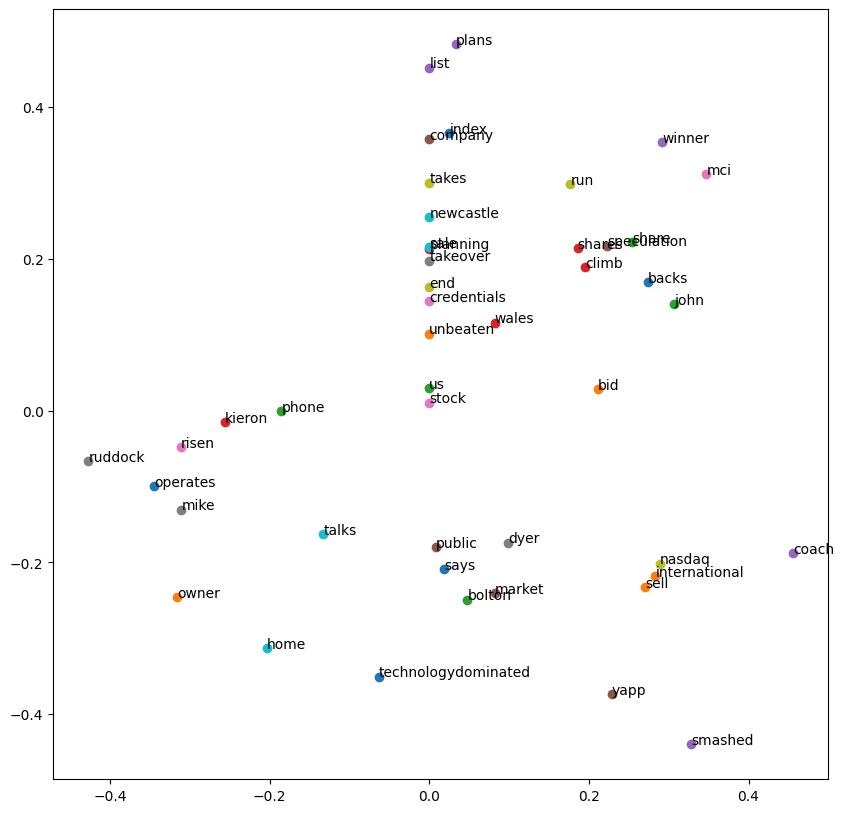

In [ ]:
# DOC2
unique_word_dict2 = create_unique_word_dict(all_text2)
n_words = len(unique_word_dict2)
print(unique_word_dict2)

# Getting all the unique words
words = list(unique_word_dict2.keys())
print(words)

# Creating the X and Y matrices using one hot encoding
print(n_words)
X = []
Y = []
for i, word_list in tqdm(enumerate(word_list2)):
    # Getting the indices
    print(word_list)
    main_word_index = unique_word_dict2.get(word_list[0])
    context_word_index = unique_word_dict2.get(word_list[1])

    print(word_list[0], main_word_index)
    print(word_list[1], context_word_index)

    # Creating the placeholders
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

# Converting the matrices into a sparse format because the vast majority of the data are 0s
print(X)
print(Y)

XX = tf.convert_to_tensor(X, dtype=tf.float32)
YY = tf.convert_to_tensor(Y, dtype=tf.float32)
print(XX.shape)
print(YY.shape)

def CreateModel():
    # Defining the size of the embedding
    embed_size = 2
    # Defining the neural network
    inp = Input(shape=XX.shape[1])
    x = Dense(units=embed_size, activation='linear')(inp)
    x = Dense(units=YY.shape[1], activation='softmax')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.summary()
    return model


model = CreateModel()
# Optimizing the network weights
model.fit( x=XX,y=YY,batch_size=10,epochs=15)

# The input layer
weights = model.get_weights()[0]
print(weights.shape)
print(weights[1][1])
print(weights)

#get the weight for each unique word
embedding_dict2 = {}
for word in words: #to pick the a row of weight of two values for each unique word
    embedding_dict2.update({
        word: weights[unique_word_dict2.get(word)]
    })
print(embedding_dict2)

#plot1

plt.figure(figsize=(10, 10))
i = 0
for word in list(unique_word_dict2.keys()):
    print(i, ' >> ', word)
    coord = embedding_dict2.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))
    i = i + 1

# The input layer
weights = model.get_weights()[0]

#plot2
plt.figure(figsize=(10, 10))
i = 0
for word in list(unique_word_dict2.keys()):
    print(i, ' >> ', word)
    # coord = embedding_dict.get(word)
    coord = embedding_dict2.get(word)
    if weights[i][0] < 0 and weights[i][1] > 0:
        plt.scatter(0, weights[i][1])
        plt.annotate(word, (0, weights[i][1]))
    else:
        plt.scatter(weights[i][0], weights[i][1])
        plt.annotate(word, (weights[i][0], weights[i][1]))


    i = i + 1

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import seaborn as sns

# Function to calculate cosine similarity
def calculate_cosine_similarity(embedding_dict):
    embeddings = np.array(list(embedding_dict.values()))
    return cosine_similarity(embeddings)

# Calculate cosine similarity for text1 and text2
similarity_matrix_text1 = calculate_cosine_similarity(embedding_dict1)
similarity_matrix_text2 = calculate_cosine_similarity(embedding_dict2)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import pairwise_distances

# Cosine similarity
embeddings = np.array(list(embedding_dict2.values()))
cosine_sim = cosine_similarity(embeddings)

# Jaccard similarity (assumes binary vectors)
jaccard_sim = 1 - pairwise_distances(embeddings > 0, metric='hamming')

# Euclidean distance (similarity)
euclidean_sim = 1 / (1 + euclidean_distances(embeddings))


In [ ]:
def analyze_similarity(similarity_matrix, method):
    # Analyze and print results for a similarity measure
    print(f"\n{method} Similarity:")
    print(similarity_matrix)
    # Additional analysis or visualizations can be added here

# Analyze and discuss each similarity measure
analyze_similarity(cosine_sim, 'Cosine')
analyze_similarity(jaccard_sim, 'Jaccard')
analyze_similarity(euclidean_sim, 'Euclidean')



Cosine Similarity:
[[ 0.99999994  0.91248405 -0.3547626  ...  0.9198669   0.9469366
  -0.00222393]
 [ 0.91248405  1.0000001   0.05878703 ...  0.67889756  0.7325675
   0.4070821 ]
 [-0.3547626   0.05878703  1.         ... -0.6930528  -0.63645166
   0.9357431 ]
 ...
 [ 0.9198669   0.67889756 -0.6930528  ...  1.          0.9971265
  -0.3942753 ]
 [ 0.9469366   0.7325675  -0.63645166 ...  0.9971265   0.99999994
  -0.32352543]
 [-0.00222393  0.4070821   0.9357431  ... -0.3942753  -0.32352543
   1.0000001 ]]

Jaccard Similarity:
[[1.  1.  0.5 ... 1.  1.  0.5]
 [1.  1.  0.5 ... 1.  1.  0.5]
 [0.5 0.5 1.  ... 0.5 0.5 1. ]
 ...
 [1.  1.  0.5 ... 1.  1.  0.5]
 [1.  1.  0.5 ... 1.  1.  0.5]
 [0.5 0.5 1.  ... 0.5 0.5 1. ]]

Euclidean Similarity:
[[1.         0.86631197 0.6778611  ... 0.8338878  0.84375787 0.64769495]
 [0.86631197 1.         0.7566535  ... 0.86462456 0.74894476 0.7135757 ]
 [0.6778611  0.7566535  1.         ... 0.7317412  0.6060874  0.8200109 ]
 ...
 [0.8338878  0.86462456 0.73174

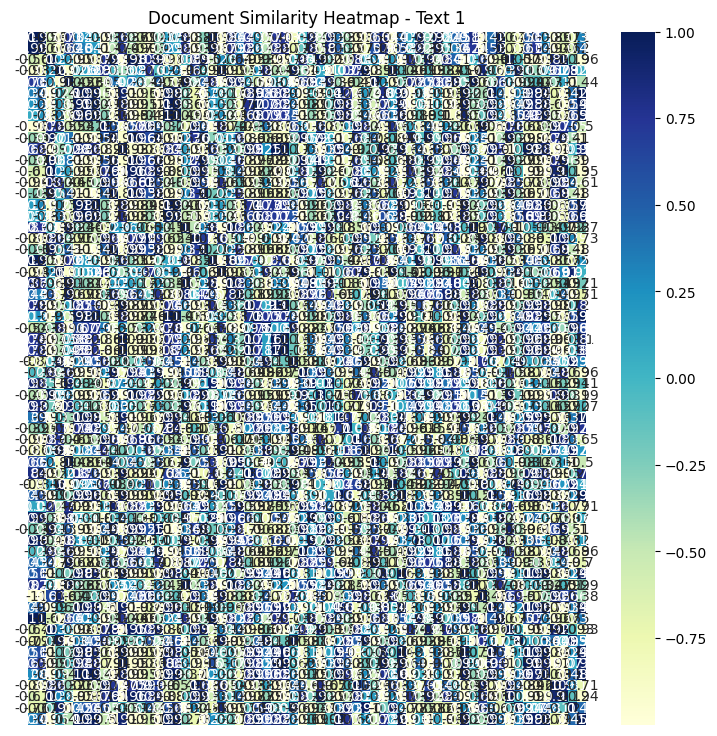

In [ ]:
plt.figure(figsize=(9, 9))
sns.heatmap(similarity_matrix_text1, annot=True, cmap="YlGnBu", xticklabels=False, yticklabels=False)
plt.title("Document Similarity Heatmap - Text 1")
plt.show()


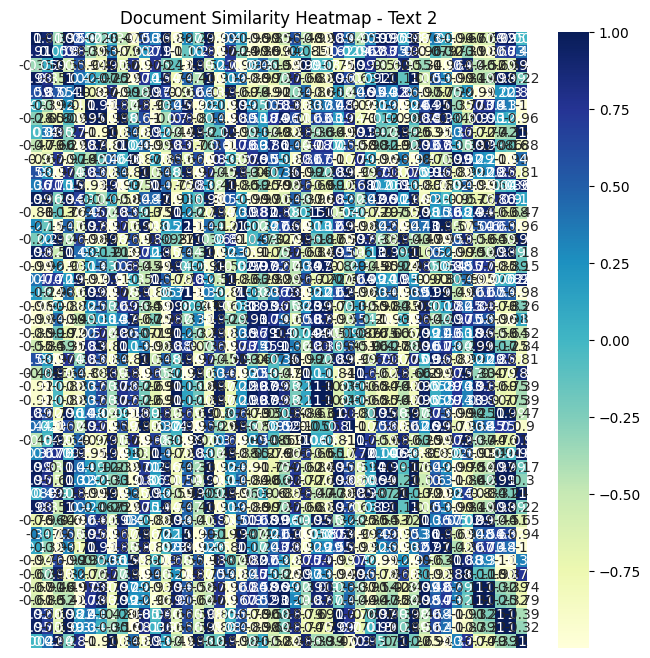

In [ ]:
# Plot heatmap for text2
plt.figure(figsize=(8, 8))
sns.heatmap(similarity_matrix_text2, annot=True, cmap="YlGnBu", xticklabels=False, yticklabels=False)
plt.title("Document Similarity Heatmap - Text 2")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


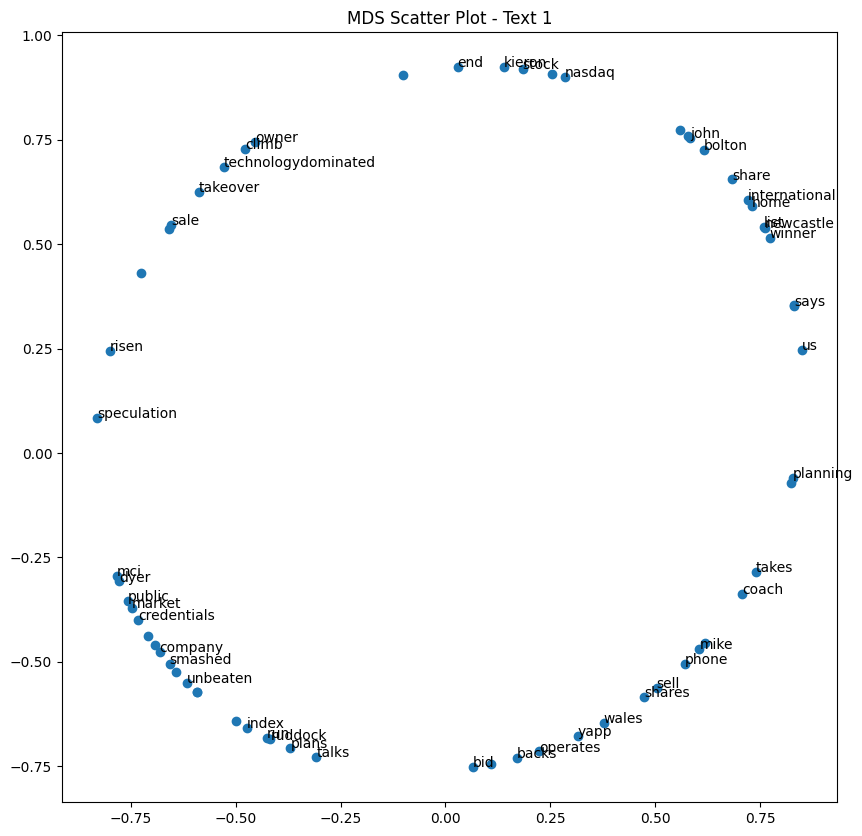

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


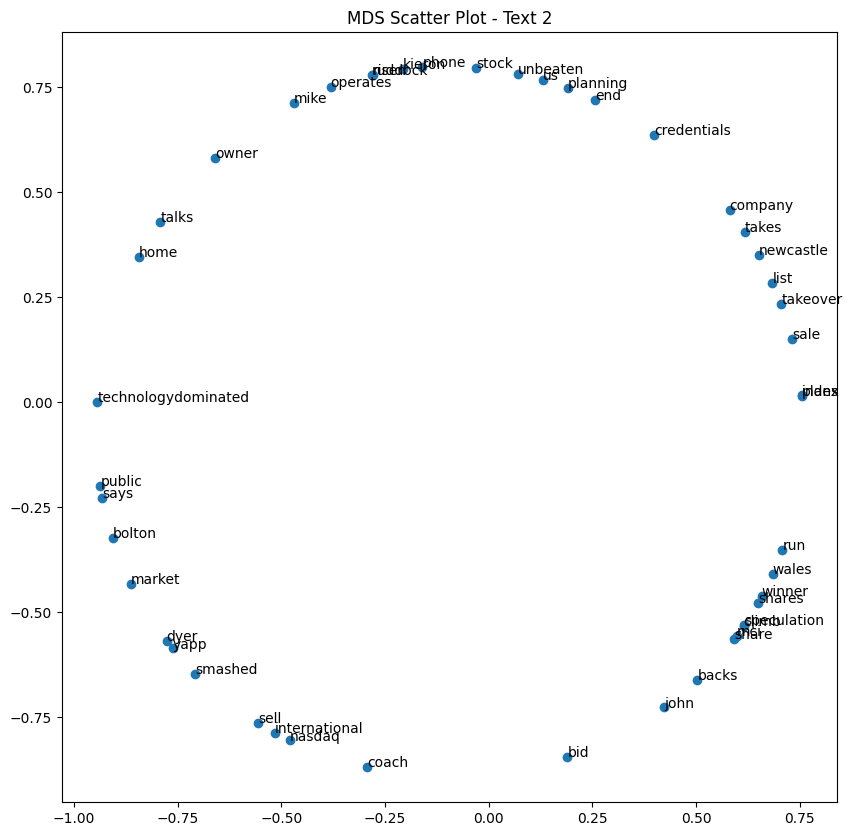

In [ ]:
# ---- Multidimensional Scaling (MDS) ----

# Function to perform MDS and plot scatter plot
def plot_mds_scatter(embedding_dict, title):
    embeddings = np.array(list(embedding_dict.values()))
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    reduced_embeddings = mds.fit_transform(1 - calculate_cosine_similarity(embedding_dict))

    plt.figure(figsize=(10, 10))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
    for i, word in enumerate(words):
        plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
    plt.title(f"MDS Scatter Plot - {title}")
    plt.show()

# Plot MDS scatter plot for text1
plot_mds_scatter(embedding_dict1, "Text 1")

# Plot MDS scatter plot for text2
plot_mds_scatter(embedding_dict2, "Text 2")
